In [78]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

df = pd.read_csv("./data/Elspotprices.csv", sep=";")
df.head()

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2024-04-13 21:00,2024-04-13 23:00,DK1,"52,590000","7,050000"
1,2024-04-13 20:00,2024-04-13 22:00,DK1,"153,679993","20,600000"
2,2024-04-13 19:00,2024-04-13 21:00,DK1,"258,500000","34,650002"
3,2024-04-13 18:00,2024-04-13 20:00,DK1,"298,630005","40,029999"
4,2024-04-13 17:00,2024-04-13 19:00,DK1,"373,760010","50,099998"


In [79]:
TRAIN_DAYS= 200

df = df[['HourDK', 'SpotPriceEUR' ]]
df['HourDK'] = pd.to_datetime(df['HourDK'])
df = df[(df['HourDK'] >= '2023-01-01') & (df['HourDK'] <= '2023-12-31')]
df = df.iloc[::-1]
df['item_id'] = 'electricity_price'
df['SpotPriceEUR'] = df['SpotPriceEUR'].str.replace(',', '.').astype(float)
df_test = df.copy()
df = df.iloc[:TRAIN_DAYS*24 - 1]
df_test = df_test.iloc[((TRAIN_DAYS-5)*24) -1:(TRAIN_DAYS+1)*24 -1]
df_test.head()


,HourDK,SpotPriceEUR,item_id
6575,2023-07-15 00:00:00,71.070000,electricity_price
6574,2023-07-15 01:00:00,51.939999,electricity_price
6573,2023-07-15 02:00:00,29.150000,electricity_price
6572,2023-07-15 03:00:00,19.950001,electricity_price
6571,2023-07-15 04:00:00,16.980000,electricity_price


In [80]:

train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="HourDK",
)
test_data = TimeSeriesDataFrame.from_data_frame(
    df_test,
    id_column="item_id",
    timestamp_column="HourDK",
)

test_data.head()

SpotPriceEUR
item_id           timestamp                        
electricity_price 2023-07-15 00:00:00     71.070000
                  2023-07-15 01:00:00     51.939999
                  2023-07-15 02:00:00     29.150000
                  2023-07-15 03:00:00     19.950001
                  2023-07-15 04:00:00     16.980000

In [81]:
predictor = TimeSeriesPredictor(
    prediction_length=24,
    path="autogluon-m4-hourly",
    target="SpotPriceEUR",
    eval_metric="MASE",
    freq="H",
)

predictor.fit(
    train_data,
    presets="high_quality",
    time_limit=600,
)

c:\energy_price_forecasting\Lib\site-packages\autogluon\timeseries\predictor.py:197: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  std_freq = pd.tseries.frequencies.to_offset(self.freq).freqstr
Frequency 'H' stored as 'h'
Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'c:\energy_price_forecasting\autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       3.48 GB / 15.73 GB (22.1%)
Disk Space Avail:   267.12 GB / 456.62 GB (58.5%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3

In [82]:
predictions = predictor.predict(train_data)
predictions.head()

data with frequency 'None' has been resampled to frequency 'h'.


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean        0.1        0.2  \
item_id           timestamp                                              
electricity_price 2023-07-20 00:00:00  96.714557  74.703428  81.779691   
                  2023-07-20 01:00:00  89.939131  60.259199  70.590447   
                  2023-07-20 02:00:00  85.150675  47.884145  61.105654   
                  2023-07-20 03:00:00  80.005475  43.562294  54.836195   
                  2023-07-20 04:00:00  82.719284  39.398471  53.451847   

                                             0.3        0.4        0.5  \
item_id           timestamp                                              
electricity_price 2023-07-20 00:00:00  86.776419  92.170393  96.714557   
                  2023-07-20 01:00:00  77.844929  84.154924  89.939131   
                  2023-07-20 02:00:00  69.260182  78.237755  85.150675   
                  2023-07-20 03:00:00  65.868806  73.079110  80.005475   
                  2023-07-20 04:00:00  65.088732  74.170483  82.719284   

                                              0.6         0.7         0.8  \
item_id           timestamp                                                 
electricity_price 2023-07-20 00:00:00  101.340215  105.861150  111.023818   
                  2023-07-20 01:00:00   95.188713  102.065420  109.909872   
                  2023-07-20 02:00:00   93.268024  100.862612  110.288296   
                  2023-07-20 03:00:00   89.504397   99.696357  109.205784   
                  2023-07-20 04:00:00   92.261177  103.071989  113.340328   

                                              0.9  
item_id           timestamp                        
electricity_price 2023-07-20 00:00:00  119.234493  
                  2023-07-20 01:00:00  120.990128  
                  2023-07-20 02:00:00  122.733974  
                  2023-07-20 03:00:00  122.180758  
                  2023-07-20 04:00:00  131.104211

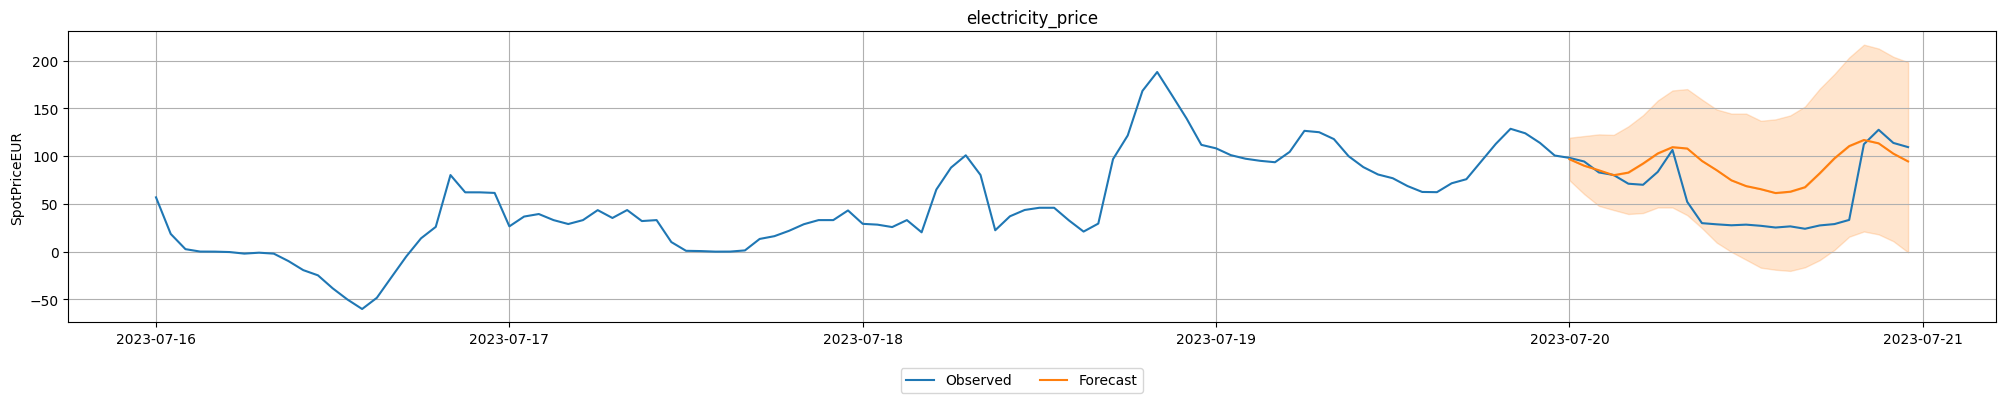

In [83]:
import matplotlib.pyplot as plt

# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=24*5, max_num_item_ids=4)

In [84]:
# The test score is computed using the last
# prediction_length=24 timesteps of each time series in test_data
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,RecursiveTabular,-0.404276,-0.787724,1.064402,0.734057,2.067372,2
1,ChronosZeroShot[bolt_base],-0.476144,-0.363592,1.082117,22.624921,0.026128,7
2,PatchTST,-0.676042,-0.601044,0.086107,0.033136,91.881637,10
3,DirectTabular,-0.746527,-0.769799,0.166118,0.146797,1.423280,3
4,NPTS,-0.765791,-0.396470,0.042564,2.081899,0.012140,4
5,TiDE,-0.773634,-0.537835,0.083206,0.010234,122.296792,11
6,WeightedEnsemble,-0.858219,-0.114148,24.837975,55.766337,0.383401,12
7,SeasonalNaive,-0.897872,-1.523774,0.038380,2.619490,0.011645,1
8,TemporalFusionTransformer,-0.913811,-0.715923,0.068049,0.033733,97.058343,8
9,DeepAR,-0.954845,-0.818041,0.104411,0.202343,75.770088,9


In [85]:
predictions = predictor.predict(train_data, model='RecursiveTabular')
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=24*5, max_num_item_ids=4)


data with frequency 'None' has been resampled to frequency 'h'.
c:\energy_price_forecasting\Lib\site-packages\autogluon\timeseries\predictor.py:1540: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False)
